In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import csv
import numpy as np
from tqdm import tqdm
import tensorflow as tf


In [2]:
DATA_PATH = '../data/'
ANNO_COARSE_PATH = DATA_PATH + 'anno_coarse'
IMG = DATA_PATH + 'img'

ATTR_CLOTH_LIST_FILE = ANNO_COARSE_PATH + '/list_attr_cloth.txt'
ATTR_IMG_LIST_FILE = ANNO_COARSE_PATH + '/list_attr_img.txt'
ATTR_TYPES = {'1':"Estampado",'2':"Tejido",'3':"Forma",'4':"Partes",'5':"Estilo"}

TRAIN_FILE = ANNO_COARSE_PATH + '/train_attr.txt'
TEST_FILE = ANNO_COARSE_PATH + '/test_attr.txt'
VAL_FILE  = ANNO_COARSE_PATH + '/val_attr.txt'

NUM_CLASSES = 1000

In [3]:
# Lectura de la lista de atributos
def read_attr_cloth_list():
    column_to_attr_name = {}
    column_to_attr_type = {}
    attr_type_to_columns = {}
    
    with open(ATTR_CLOTH_LIST_FILE) as fp: 
        fp.readline() # Ingorar numero de etiquetas
        fp.readline() # Ignorar cabecera
        column = 0
        for line in fp: 
            fields = line.split()
            attr = " ".join(fields[:-1])
            attr_type = fields[-1]
            column_to_attr_name[column] = attr
            column_to_attr_type[column] = attr_type
            if attr_type in attr_type_to_columns:
                attr_type_to_columns[attr_type].append(column)
            else:
                attr_type_to_columns[attr_type] = [column]
            column += 1
    return column_to_attr_name, attr_type_to_columns, column_to_attr_type

# Lectura de atributos asociados a una imagen
def read_attr_img_list():
    attr_dict = []
    with open(ATTR_IMG_LIST_FILE) as fp: 
        fp.readline() # Ingorar numero de lineas
        fp.readline() # Ignorar cabecera
        for line in fp:
            row = [int(i) for i in line.split()[1:]]
            attr_dict.append(row)
    return pd.DataFrame.from_records(attr_dict)


In [27]:
column_to_attr_name, attr_type_to_columns, column_to_attr_type = read_attr_cloth_list()           
attr_img_list = read_attr_img_list()    
attributes = list(column_to_attr_name.values())

In [5]:
# Análisis del número mínimo y máximo de atributos que puede tener una imagen
num_attr_per_img = (attr_img_list == 1).astype(int).sum(axis=1)
print(min(num_attr_per_img))
print(max(num_attr_per_img))

0
21


In [6]:
num_attr_per_img[num_attr_per_img == 21]

178507    21
dtype: int64

In [7]:

num_attr_per_img[num_attr_per_img == 5]

14        5
31        5
32        5
37        5
49        5
         ..
289143    5
289154    5
289196    5
289213    5
289214    5
Length: 32119, dtype: int64

Text(0.5, 1.0, 'Num. atributos por imagen')

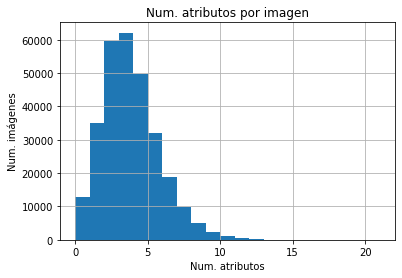

In [8]:
h = num_attr_per_img.hist(bins=21)
h.set_xlabel("Num. atributos")
h.set_ylabel("Num. imágenes")
h.set_title("Num. atributos por imagen")

In [9]:
num_attr_per_img.describe()

count    289222.000000
mean          3.322742
std           1.956819
min           0.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          21.000000
dtype: float64

In [10]:
# Análisis del número mínimo y máximo de atributos que puede tener una imagen
num_img_per_attr = (attr_img_list == 1).astype(int).sum(axis=0)
print(min(num_img_per_attr))
print(max(num_img_per_attr))

51
37367


Text(0.5, 1.0, 'Num. imágenes en los que aparece un atributo')

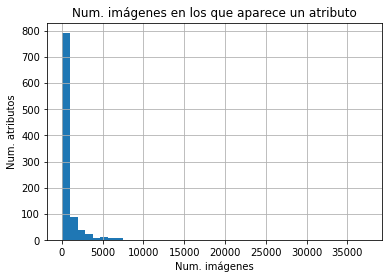

In [11]:
h = num_img_per_attr.hist(bins=40)
h.set_xlabel("Num. imágenes")
h.set_ylabel("Num. atributos")
h.set_title("Num. imágenes en los que aparece un atributo")

In [12]:
num_img_per_attr.describe()

count     1000.000000
mean       961.010000
std       2341.581377
min         51.000000
25%        107.000000
50%        258.000000
75%        767.250000
max      37367.000000
dtype: float64

In [13]:
data = {'count':list(num_img_per_attr), 'i':list(column_to_attr_name.keys()) }
df = pd.DataFrame(data, index=list(column_to_attr_name.values()))
df["type"] = df.apply(lambda row: column_to_attr_type[row['i']], axis = 1) 

df = df.sort_values(by=['count'], ascending=False)

print(df.head(10))
print(df.tail(10))



         count    i type
print    37367  730    1
floral   24188  365    1
lace     20434  513    2
knit     18498  495    2
sleeve   17828  836    4
maxi     15990  596    3
shirt    14920  822    3
denim    13178  254    2
striped  11771  884    1
chiffon  11735  142    2
                  count    i type
ornate paisley       52  672    1
high-rise skinny     52  464    3
boxy lace            52   96    3
defyant              52  253    5
print smock          52  737    3
deep-v               51  252    4
floral textured      51  387    1
topstitched          51  925    4
raw-cut              51  758    3
floral flutter       51  366    1


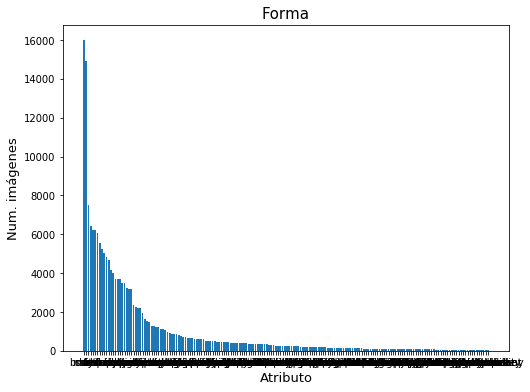

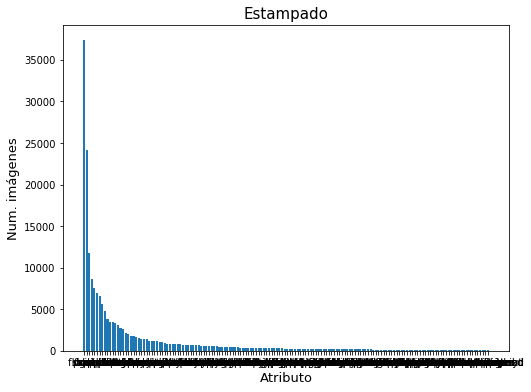

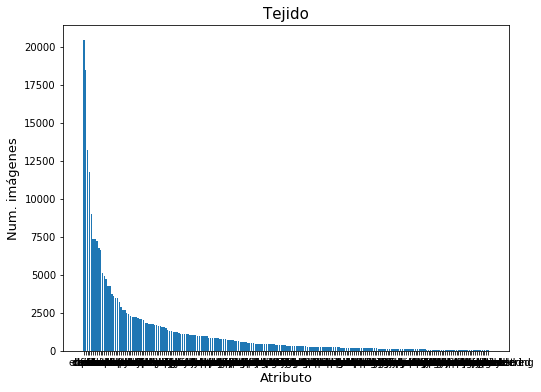

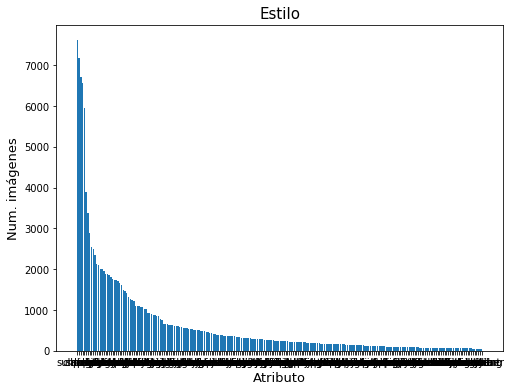

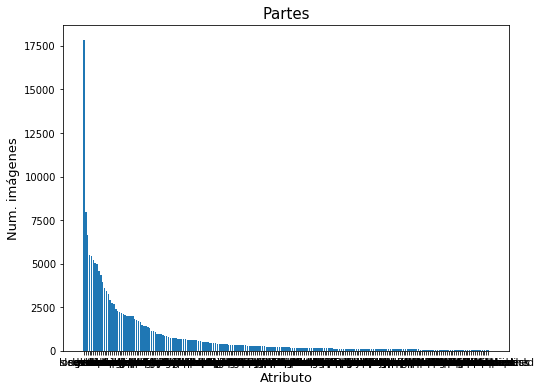

In [14]:
# Análisis de frecuencias dentro de cada tipo de atributo
num_occ_per_attr = (attr_img_list == 1).astype(int).sum(axis=0)
num_occ_per_attr.loc[1]
count = 1
figs = []
for attr_type, columns in attr_type_to_columns.items():
    labels = [column_to_attr_name[c] for c in columns]
    counts = [num_occ_per_attr.loc[c] for c in columns]
    
    df = pd.DataFrame(counts, index=labels, columns=["count"])
    df = df.sort_values(by=['count'], ascending=False)
    
    plt.figure(figsize=(8,6))
    plt.title(ATTR_TYPES[attr_type], fontsize=15)
    plt.xlabel("Atributo", fontsize=13)
    plt.ylabel("Num. imágenes", fontsize=13)
    plt.bar(df.index.values,df['count'])
    plt.show()    

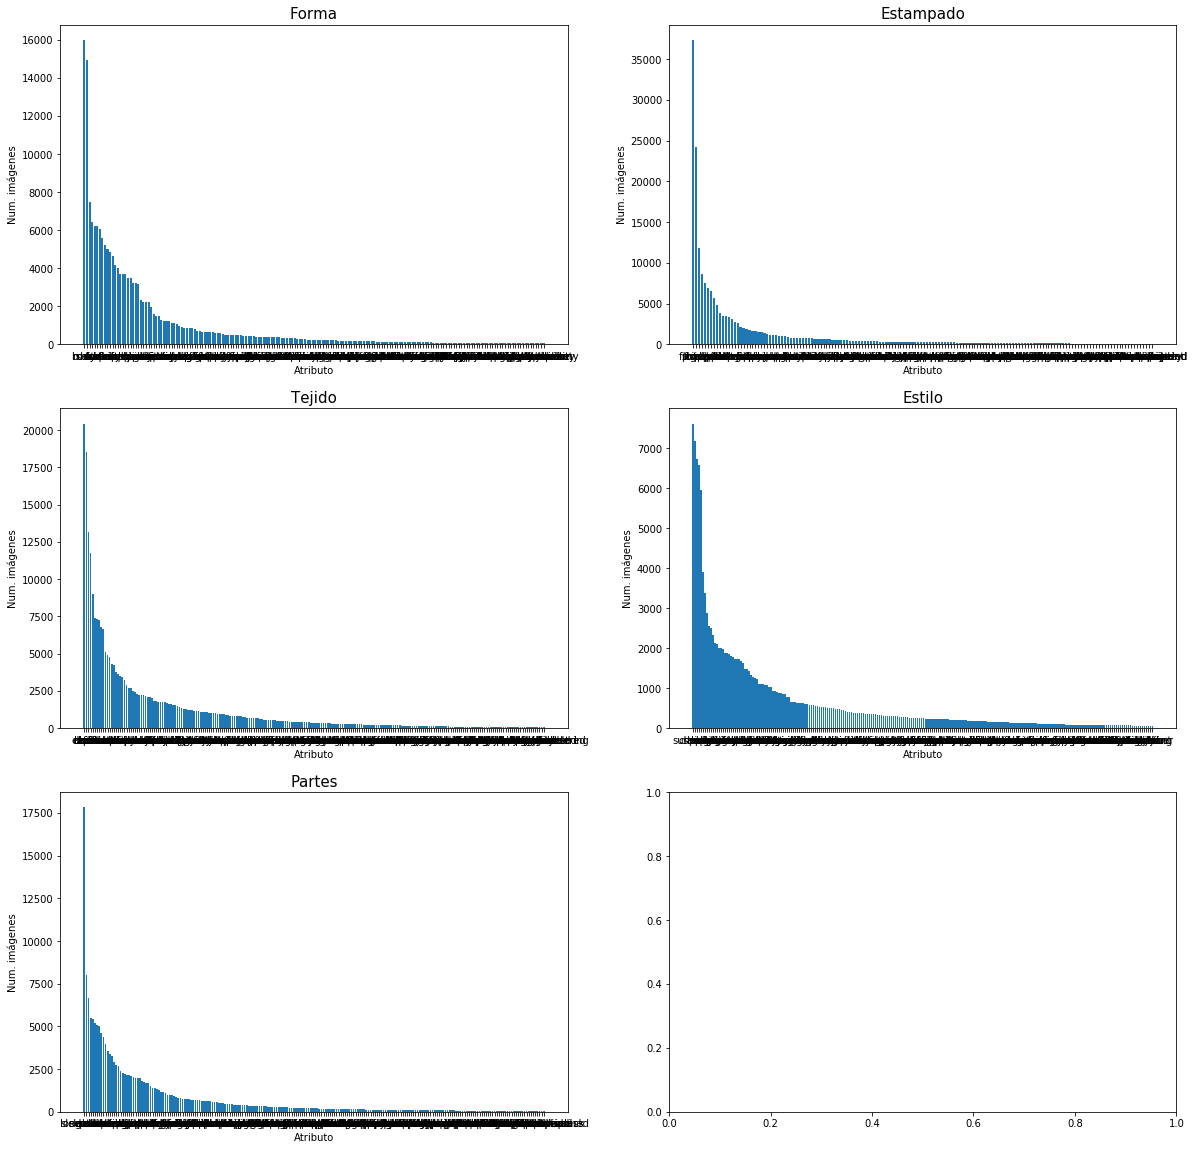

In [15]:
# Análisis de frecuencias dentro de cada tipo de atributo
num_occ_per_attr = (attr_img_list == 1).astype(int).sum(axis=0)
num_occ_per_attr.loc[1]
count = 0
figs = []
fig, axs = plt.subplots(3, 2, figsize=(20, 20))

for attr_type, columns in attr_type_to_columns.items():
    labels = [column_to_attr_name[c] for c in columns]
    counts = [num_occ_per_attr.loc[c] for c in columns]
    
    r = count // 2
    c = count % 2
    
    df = pd.DataFrame(counts, index=labels, columns=["count"])
    df = df.sort_values(by=['count'], ascending=False)
    
    axs[r, c].set_title(ATTR_TYPES[attr_type], fontsize=15)
    axs[r, c].set(xlabel='Atributo', ylabel='Num. imágenes')
    axs[r, c].bar(df.index.values,df['count'])
    count += 1
#plt.show()    
plt.savefig('foo.png')

In [16]:
a = attr_img_list.iloc[49]


[column_to_attr_name[c] for c in a[a == 1].index]

['button', 'flared', 'layered', 'peplum', 'pleated']

In [17]:
def build_partition_distribution_table():

     # Carga de las anotaciones reales de la partición de entrenamiento
    partition_attribute_filepath = ANNO_COARSE_PATH + "/train_attr.txt"
    y_true_train = pd.read_csv(partition_attribute_filepath, sep = ' ', names = [str(i) for i in range(0,NUM_CLASSES)], index_col=False)
    
     # Carga de las anotaciones reales de la partición de valiación
    partition_attribute_filepath = ANNO_COARSE_PATH + "/val_attr.txt"
    y_true_val = pd.read_csv(partition_attribute_filepath, sep = ' ', names = [str(i) for i in range(0,NUM_CLASSES)], index_col=False)
    
    # Carga de las anotaciones reales de la partición de test
    partition_attribute_filepath = ANNO_COARSE_PATH + "/test_attr.txt"
    y_true_test = pd.read_csv(partition_attribute_filepath, sep = ' ', names = [str(i) for i in range(0,NUM_CLASSES)], index_col=False)

    # Columna de tipo de atributo
    attr_types = []
    for k, v in attr_type_to_columns.items():
        attr_types.extend([ATTR_TYPES[str(k)]] * len(v))

    # Columnas de frecuencia real
    frequency_train = y_true_train.sum().tolist()
    frequency_val = y_true_val.sum().tolist()
    frequency_test = y_true_test.sum().tolist()

    # Creación de dataframe
    d = {'Atributo': attributes, 'Tipo': attr_types, 'Frecuencia train' : frequency_train, 
         'Frecuencia val' : frequency_val, 'Frecuencia test': frequency_test}
    return pd.DataFrame(data=d)

In [18]:
#build_partition_distribution_table()

In [19]:
ATTR_IMG_LIST_FILE = ANNO_COARSE_PATH + '/list_attr_img.txt'
PARTITION_FILE = ANNO_COARSE_PATH + '/list_eval_partition.txt'

In [20]:
def read_partition_files():
    data = {}
    data['train'] = []
    data['test'] = []
    data['val'] = []
    with open(PARTITION_FILE) as fp:
        fp.readline() # Ingorar numero de etiquetas
        fp.readline() # Ingorar numero de etiquetas
        for line in fp:
            fields = line.split()
            
            img_path = fields[0]           
            partition = fields[1]
            data[partition].append(img_path)
    return data

In [21]:
partitions = read_partition_files()

In [22]:
def split():
    with open(ATTR_IMG_LIST_FILE) as fp, open(TRAIN_FILE, 'w', newline='') as train_file,open(VAL_FILE, 'w', newline='') as val_file, open(TEST_FILE, 'w', newline='') as test_file:
          
        train_wr = csv.writer(train_file, delimiter=' ')
        test_wr = csv.writer(test_file, delimiter=' ')
        val_wr = csv.writer(val_file, delimiter=' ')

        fp.readline() # Ingorar numero de etiquetas
        fp.readline() # Ingorar numero de etiquetas
        for line in tqdm(fp):
            
            fields = ['0' if f=='-1' else f for f in line.split()]
            img_path = fields[0]
            
            fields[0] = fields[0].replace('img/', '').replace('/','')
            
            if img_path in partitions['train']:
                train_wr.writerow(fields)
            elif img_path in partitions['val']:
                val_wr.writerow(fields)
            elif img_path in partitions['test']:
                test_wr.writerow(fields)
            else:
                print(img_path)


In [23]:
#split()

In [24]:
len(partitions['test'])

40000

In [25]:
def show_frequencies(df):
    attr_types = []
    for k, v in attr_type_to_columns.items():
        attr_types.extend([ATTR_TYPES[str(k)]] * len(v))

    # Columnas de frecuencia real
    df = df.drop(columns=['filename'])
    frequency_train = df.sum().tolist()

    # Creación de dataframe
    d = {'Atributo': attributes, 'Tipo': attr_types, 'Frecuencia train' : frequency_train}
    return pd.DataFrame(data=d)

In [28]:
# Recupera el fichero con el dataframe de atributos por imagen, y añade la columna filename
def get_train_data():
    partition_attribute_filepath = ANNO_COARSE_PATH + "/train_attr.txt"
    data = pd.read_csv(partition_attribute_filepath, sep = ' ', names = attributes , index_col=False)
    return data

df = get_train_data()


In [30]:
df = df.drop_duplicates(subset=attributes)
print('Número de combinaciones de atributos distintas: {}'.format(len(df)))
# Guardamos en fichero para ser usado desde otro notebook
df.to_csv(ANNO_COARSE_PATH + "/coarse_no_dupe.txt", index=False, header=True, sep=' ')


Número de combinaciones de atributos distintas: 209222


In [ ]:
    
#show_frequencies(df)

In [33]:
# Recupera el fichero con el dataframe de atributos por imagen, y añade la columna filename
def get_train_data():
    partition_attribute_filepath = ANNO_COARSE_PATH + "/train_attr.txt"
    data = pd.read_csv(partition_attribute_filepath, sep = ' ', names = attributes , index_col=False)
    
    return data

# Genera array de pesos ordenando los atributos dentro de su tipo de atributo en base al número de ocurrencias
# en la partición de train.
def get_attribute_weights():
    df = build_partition_distribution_table()
    d = {}
    for i,attr_type in ATTR_TYPES.items():
        attr_type_df = df.loc[df['Tipo'] == attr_type].sort_values(by=['Frecuencia train'])

        attr_type_df['weight'] = np.arange(len(attr_type_df))
        r, c = attr_type_df.shape
        attr_type_df['weight'] = attr_type_df['weight'].apply(lambda x: x/c)
        s = pd.Series(attr_type_df.weight.values,index=attr_type_df.Atributo).to_dict()
        d.update(s)
        
    r = [d[v] for v in column_to_attr_name.values()]
    return r

# Aplica el array de pesos a las etiquetas positivas de una fila del dataframe
def rank(row, weights):
    r = 0
    for i,w in enumerate(weights):
        r+=row[i]*w
    return r

TO_REPLACE = 80000 # 40% del dataset
BATCH_SIZE = 2000
NUM_BATCHES = TO_REPLACE // BATCH_SIZE

def get_oversampled_dataset():
    # Importa el dataframe
    train = get_train_data()
    # Genera array de pesos por atributo
    weights = get_attribute_weights()

    # Añade columna con el ranking y ranking inverso de cada columna
    train['rank'] = train.apply(lambda x: rank(x, weights),axis=1)
    train['rank_inv'] = train.apply(lambda x: 1/rank(x, weights),axis=1)
    
    train = train.sort_values(by=['rank'])
    
    for i in tqdm(range(0, NUM_BATCHES)):
        
        p_25 = np.percentile(train['rank'], 25)
        p_75 = np.percentile(train['rank'], 75)
    
        # Undersampling - Elimina N columnas aleatorias dentro de aquellas con un ranking superior al p75
        train = train.drop(train[train['rank'] > p_75].sample(n=BATCH_SIZE, weights='rank', random_state=1).index)
        # Oversampling - Duplica N columnas aleatorias dentro de aquellas con un ranking inferior al p25
        train = train.append(train[train['rank'] < p_25].sample(n=BATCH_SIZE, weights='rank_inv', random_state=1), ignore_index = True)

    train = train.sort_values(by=['rank'])
    train = train.drop(columns=['rank', 'rank_inv'])
    return train

def show_frequencies(df):
    attr_types = []
    for k, v in attr_type_to_columns.items():
        attr_types.extend([ATTR_TYPES[str(k)]] * len(v))

    # Columnas de frecuencia real
    df = df.drop(columns=['filename'])
    frequency_train = df.sum().tolist()

    # Creación de dataframe
    d = {'Atributo': attributes, 'Tipo': attr_types, 'Frecuencia train' : frequency_train}
    return pd.DataFrame(data=d)

In [36]:
df = get_oversampled_dataset()
# Guardamos en fichero para ser usado desde otro notebook
df.to_csv(ANNO_COARSE_PATH + "/oversampled.txt", index=False, header=True, sep=' ')

TypeError: '<' not supported between instances of 'int' and 'str'

In [39]:
print(tf.__version__)

2.1.0


In [41]:
import keras
print(keras.__version__)

2.3.1


Using TensorFlow backend.
